<h3>Install Necessary Libraries</h3>

First, we need to install and import the required libraries for data processing, chemical informatics, and machine learning.

In [ ]:
#Install necessary libraries
!pip install rdkit chembl_webresource_client
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.1 MB/s eta 0:00:00


<h3>Data Retrieval and Initial Processing<h3>

In this section, we retrieve activity data for COX-2 inhibitors from the ChEMBL database and load it into a pandas DataFrame for initial processing.

In [ ]:
target = new_client.target
activity = new_client.activity

cox2 = target.filter(pref_name="Cyclooxygenase-2").only('target_chembl_id')[0]

activities = activity.filter(target_chembl_id=cox2['target_chembl_id'])
df = pd.DataFrame.from_dict(activities)[:1000]

print(df.shape)
print(df['standard_type'].value_counts())
print(df['standard_units'].value_counts())


(1000, 46)
standard_type
IC50          749
Inhibition    231
NT             20
Name: count, dtype: int64
standard_units
nM    749
%     207
uM     24
Name: count, dtype: int64


2

In [ ]:
df = df[['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'standard_type', 'standard_units']]
df = df.dropna()

print("Shape after initial filtering:", df.shape)

Shape after initial filtering: (975, 5)


<h3>Data Cleaning and Transformation</h3>

This section focuses on cleaning the data by filtering for IC50 values, converting units to nM, and calculating pIC50 values.

In [ ]:
# Filter for IC50 values and convert units
df = df[df['standard_type'] == 'IC50']
df.loc[df['standard_units'] == 'uM', 'standard_value'] *= 1000
df = df[df['standard_units'].isin(['nM', 'uM'])]  # Keep only nM and uM (now converted to nM)

print("Shape after filtering for IC50 and unit conversion:", df.shape)

df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')
df = df.dropna(subset=['standard_value'])

print("Shape after converting to numeric:", df.shape)

Shape after filtering for IC50 and unit conversion: (744, 5)
Shape after converting to numeric: (744, 5)


<ipython-input-5-6069bcd4db15>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['standard_units'] == 'uM', 'standard_value'] *= 1000


In [ ]:
# Convert IC50 values to pIC50
df['pIC50'] = -np.log10(df['standard_value'] * 1e-9)

print("pIC50 statistics:")
print(df['pIC50'].describe())

pIC50 statistics:
count    744.000000
mean       6.515338
std        1.297821
min        3.000000
25%        5.663283
50%        6.565443
75%        7.522879
max       10.096910
Name: pIC50, dtype: float64


<h3>Exploratory Data Analysis</h3>

In this part, we analyze the distribution of pIC50 values to understand the characteristics of our dataset.

In [ ]:
# Check for infinities or very large/small values
print("\nInfinite values in pIC50:", np.isinf(df['pIC50']).sum())
print("pIC50 values above 15 or below 0:", ((df['pIC50'] > 15) | (df['pIC50'] < 0)).sum())


Infinite values in pIC50: 0
pIC50 values above 15 or below 0: 0


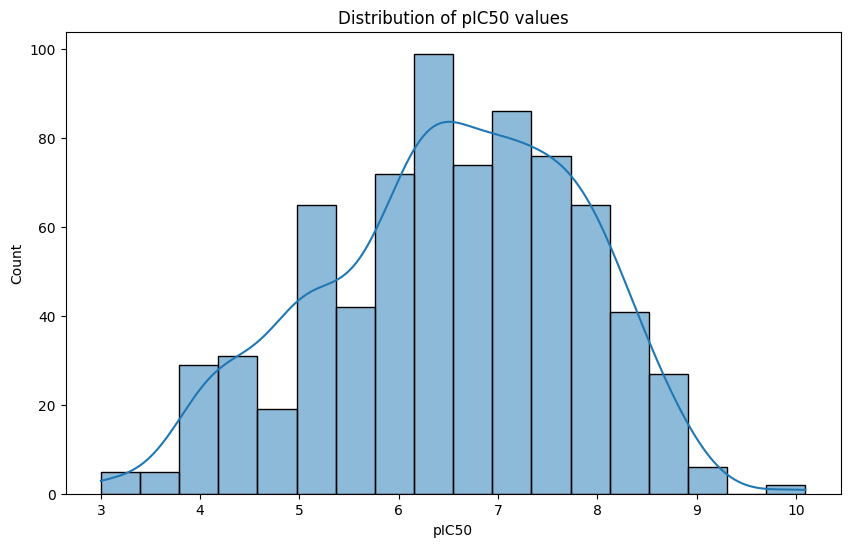

In [ ]:
# Plot distribution of pIC50 values
plt.figure(figsize=(10, 6))
sns.histplot(df['pIC50'], kde=True)
plt.title('Distribution of pIC50 values')
plt.xlabel('pIC50')
plt.ylabel('Count')
plt.show()

<h3>Feature Generation</h3>

Here, we generate Morgan fingerprints for each molecule, representing their chemical structures in a binary format suitable for machine learning.

3

In [ ]:
# Function to compute Morgan fingerprints using MorganGenerator
def compute_fingerprint(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        generator = AllChem.GetMorganGenerator(radius=radius, fpSize=nBits)
        fp = generator.GetFingerprint(mol)
        return fp
    return None

In [ ]:
# Compute fingerprints for each molecule
df['fingerprint'] = df['canonical_smiles'].apply(compute_fingerprint)

In [ ]:
# Convert fingerprints to binary features
def fingerprint_to_binary(fp):
    if fp is not None:
        return list(fp)
    return [0] * 1024  # Return a list of zeros if fingerprint is None

fingerprint_bits = df['fingerprint'].apply(fingerprint_to_binary)
fingerprint_features = pd.DataFrame(fingerprint_bits.tolist(), columns=[f'bit_{i}' for i in range(1024)])

In [ ]:
# Combine fingerprint features with pIC50 values
X = fingerprint_features
y = df['pIC50']

print("Shape of feature matrix X:", X.shape)
print("Shape of target vector y:", y.shape)

Shape of feature matrix X: (744, 1024)
Shape of target vector y: (744,)


<h3>Model Training and Evaluation</h3>

We split the data into training and test sets, train a Random Forest regression model, and evaluate its performance.

In [ ]:
# Check for NaN or infinite values
print("NaN values in X:", X.isna().sum().sum())
print("NaN values in y:", y.isna().sum())
print("Infinite values in X:", np.isinf(X).sum().sum())
print("Infinite values in y:", np.isinf(y).sum())

NaN values in X: 0
NaN values in y: 0
Infinite values in X: 0
Infinite values in y: 0


In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Predict and evaluate the model
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Train R2:", r2_score(y_train, y_pred_train))
print("Test R2:", r2_score(y_test, y_pred_test))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))


Train R2: 0.9024334702752398
Test R2: 0.6376152083522095
Test RMSE: 0.76600336721846


<h3>Feature Importance Analysis</h3>

Finally, we analyze the importance of each fingerprint bit to understand which features are most relevant for predicting pIC50 values.

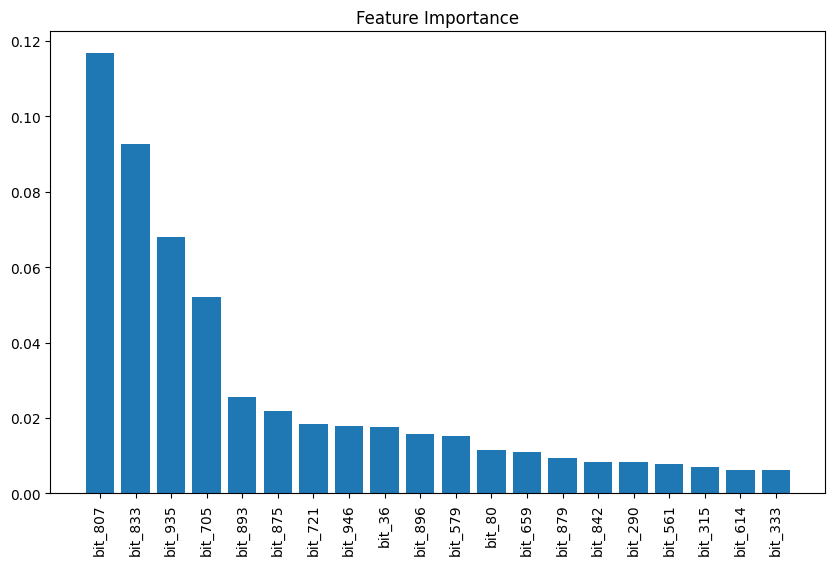

In [ ]:
# Analyze feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = [f'bit_{i}' for i in range(1024)]
sorted_features = [features[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), sorted_features[:20], rotation=90)
plt.show()